In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import tensorflow as tf

# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False


Plan:
 - Load sets
 - Clean:
    - remove duplicate entries from sets
    - Drop the unimportant coloumns that we found
    - Make querters into hours
    - remove values from train_targets that are nan in both x and y sets
    - make time features
    - drop datetime coloumns
 - Set prep:
    - 75/25 fordeling. 75% av OBSERVED er trening, resterende 25% er validation, 75% av ESTIMATED er trening, resterende 25% er validation
- Concat the different locations into 1 set, where location is a feature as well
   - 1 hot encoding
- Make a time series model

#### Loading all datasets

In [2]:
#A
y_a = pd.read_parquet('../data/A/train_targets.parquet')
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')

# B
y_b = pd.read_parquet('../data/B/train_targets.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')

# C
y_c = pd.read_parquet('../data/C/train_targets.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

#### Removing duplicate entries from the sets if any exists

In [3]:
# Function that removes the duplicates if it finds duplicates in the specified coloumn
def remove_duplicates_in_coloumn(df, col):
    duplicate_mask = df[col].duplicated(keep="first")
    if duplicate_mask.any():
        df = df[~duplicate_mask]
    return df

In [4]:
#A
y_a = remove_duplicates_in_coloumn(y_a, "time")
X_test_estimated_a = remove_duplicates_in_coloumn(X_test_estimated_a, "date_forecast")
X_train_estimated_a = remove_duplicates_in_coloumn(X_train_estimated_a, "date_forecast")
X_train_observed_a = remove_duplicates_in_coloumn(X_train_observed_a, "date_forecast")

#B
y_b = remove_duplicates_in_coloumn(y_b, "time")
X_test_estimated_b = remove_duplicates_in_coloumn(X_test_estimated_b, "date_forecast")
X_train_estimated_b = remove_duplicates_in_coloumn(X_train_estimated_b, "date_forecast")
X_train_observed_b = remove_duplicates_in_coloumn(X_train_observed_b, "date_forecast")

#C
y_c = remove_duplicates_in_coloumn(y_c, "time")
X_test_estimated_c = remove_duplicates_in_coloumn(X_test_estimated_c, "date_forecast")
X_train_estimated_c = remove_duplicates_in_coloumn(X_train_estimated_c, "date_forecast")
X_train_observed_c = remove_duplicates_in_coloumn(X_train_observed_c, "date_forecast")


In [5]:
#list of all estimated and observed sets

list_of_all_estimated_and_observed_sets = [X_test_estimated_a, X_train_estimated_a, X_train_observed_a,
                                           X_test_estimated_b, X_train_estimated_b, X_train_observed_b,
                                           X_test_estimated_c, X_train_estimated_c, X_train_observed_c]

#### Dropping some coloumns for the bants

In [6]:
for set in list_of_all_estimated_and_observed_sets:
    # set.drop("snow_density:kgm3", axis=1, inplace=True)
    # these 2 had a lot of NaN values
    set.drop("ceiling_height_agl:m", axis=1, inplace=True) 
    set.drop("cloud_base_agl:m", axis=1,inplace=True) # could potentially not drop this, but set all nan values to 0
    set.drop("snow_density:kgm3", axis=1, inplace=True)
    set.drop("elevation:m", axis=1, inplace=True) 
    set.drop("precip_5min:mm", axis=1, inplace=True)
    set.drop("precip_type_5min:idx", axis=1, inplace=True)
    set.drop("pressure_50m:hPa", axis=1, inplace=True)
    set.drop("snow_drift:idx", axis=1, inplace=True)
    set.drop("wind_speed_u_10m:ms", axis=1, inplace=True)
    set.drop("wind_speed_v_10m:ms", axis=1, inplace=True)
    set.drop("wind_speed_w_1000hPa:ms", axis=1, inplace=True)

#### Converting degree features to vector

In [7]:
def convert_from_degree_to_ciruclar(df, feature):
    df[feature+'_sin'] = np.sin(np.radians(df[feature]))
    df[feature+'_cos'] = np.cos(np.radians(df[feature]))
    df = df.drop(feature, axis = 1)
    return df

In [8]:
print(X_test_estimated_a.shape)

X_train_estimated_a = convert_from_degree_to_ciruclar(X_train_estimated_a, "sun_azimuth:d")
X_train_observed_a = convert_from_degree_to_ciruclar(X_train_observed_a, "sun_azimuth:d")
X_test_estimated_a = convert_from_degree_to_ciruclar(X_test_estimated_a, "sun_azimuth:d")
X_train_estimated_b = convert_from_degree_to_ciruclar(X_train_estimated_b, "sun_azimuth:d")
X_train_observed_b = convert_from_degree_to_ciruclar(X_train_observed_b, "sun_azimuth:d")
X_test_estimated_b = convert_from_degree_to_ciruclar(X_test_estimated_b, "sun_azimuth:d")
X_train_estimated_c = convert_from_degree_to_ciruclar(X_train_estimated_c, "sun_azimuth:d")
X_train_observed_c = convert_from_degree_to_ciruclar(X_train_observed_c, "sun_azimuth:d")
X_test_estimated_c = convert_from_degree_to_ciruclar(X_test_estimated_c, "sun_azimuth:d")

print(X_test_estimated_a.shape)

# X_train_observed_a.head()

(2880, 36)
(2880, 37)


#### Removing date_calc from all estimated sets


In [9]:
X_test_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_test_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_test_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c.drop("date_calc", axis=1, inplace=True)

#### Converting every 4 quarters into an whole hour

In [10]:
## It might be better not to resample actually, but just use the actual hours that correspond perfectly

def convert_df_into_hourly(df):
    df.set_index("date_forecast", inplace=True)
    df = df.resample('1H').sum()
    df.reset_index(inplace=True)
    return df

In [11]:

print(X_test_estimated_a.shape)

X_train_estimated_a = convert_df_into_hourly(X_train_estimated_a)
X_train_observed_a = convert_df_into_hourly(X_train_observed_a)
X_test_estimated_a = convert_df_into_hourly(X_test_estimated_a)
X_train_estimated_b = convert_df_into_hourly(X_train_estimated_b)
X_train_observed_b = convert_df_into_hourly(X_train_observed_b)
X_test_estimated_b = convert_df_into_hourly(X_test_estimated_b)
X_train_estimated_c = convert_df_into_hourly(X_train_estimated_c)
X_train_observed_c = convert_df_into_hourly(X_train_observed_c)
X_test_estimated_c = convert_df_into_hourly(X_test_estimated_c)

print(X_test_estimated_a.shape)

X_train_estimated_a.head()
## We should probably do it for the test_sets here as well


(2880, 36)
(1536, 36)


,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,snow_melt_10min:mm,snow_water:kgm2,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,sun_azimuth:d_sin,sun_azimuth:d_cos
0,2022-10-28 22:00:00,33.400002,4.932,0.0,0.0,4.0,1125.099976,0.0,0.0,0.0,...,0.0,1.9,-156.261002,0.0,1138.700073,400.0,82850.101562,2.800000,-0.840212,3.893597
1,2022-10-28 23:00:00,32.400002,4.936,0.0,0.0,4.0,1123.400024,0.0,0.0,0.0,...,0.0,2.8,-157.529007,0.0,1137.300049,400.0,22496.699219,3.100000,0.468029,3.955367
2,2022-10-29 00:00:00,32.599998,4.919,0.0,0.0,4.0,1123.699951,0.0,0.0,0.0,...,0.0,4.7,-152.162003,0.8,1135.500000,400.0,12961.700195,6.000000,1.635808,3.632862
3,2022-10-29 01:00:00,32.799999,4.914,0.0,0.0,4.0,1124.199951,0.0,0.0,0.0,...,0.0,3.5,-137.561996,1.0,1137.400024,400.0,12974.000000,6.300000,2.658692,2.970362
4,2022-10-29 02:00:00,33.500000,4.908,0.0,0.0,4.0,1125.399902,0.0,0.0,0.0,...,0.0,4.0,-117.074997,1.0,1138.099976,400.0,10113.799805,8.799999,3.382308,2.114047


#### Removing all NaN from y_targets
 - Removing all NaN from y_targets and their corresponding dates in the X_train sets, both observed and estimated
 

In [12]:
#Function that returns train_targets, observed and estimated sets left after filtering away NaN
def drop_nan_rows_in_target_and_train(y_df, observed_train_df, estimated_train_df):
    y_df = y_df.dropna(subset=['pv_measurement'])
    valid_dates = y_df['time']
    observed_train_df = observed_train_df[observed_train_df['date_forecast'].isin(valid_dates)]
    estimated_train_df = estimated_train_df[estimated_train_df['date_forecast'].isin(valid_dates)]
    return (y_df, observed_train_df, estimated_train_df)

In [13]:
#doing the NaN filtering
y_a, X_train_observed_a, X_train_estimated_a = drop_nan_rows_in_target_and_train(y_a, X_train_observed_a, X_train_estimated_a)
y_b, X_train_observed_b, X_train_estimated_b = drop_nan_rows_in_target_and_train(y_b, X_train_observed_b, X_train_estimated_b)
y_c, X_train_observed_c, X_train_estimated_c = drop_nan_rows_in_target_and_train(y_c, X_train_observed_c, X_train_estimated_c)

y_c.head()

,time,pv_measurement
5913,2019-09-04 08:00:00,137.2
5914,2019-09-04 09:00:00,0.0
5915,2019-09-04 10:00:00,0.0
5916,2019-09-04 11:00:00,0.0
5917,2019-09-04 12:00:00,0.0


In [14]:
X_train_observed_c.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,snow_melt_10min:mm,snow_water:kgm2,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,sun_azimuth:d_sin,sun_azimuth:d_cos
5912,2019-09-04 08:00:00,26.5,4.883,5283377.5,1684.900024,0.0,1112.800049,271.899994,9.320397e+05,1352.599976,...,0.0,0.0,103.019997,0.0,1134.900024,124.799995,198197.796875,5.0,3.039486,-2.582547
5913,2019-09-04 09:00:00,25.1,4.857,6726922.0,2032.500000,0.0,1109.699951,306.500000,1.041404e+06,1624.199951,...,0.0,0.0,120.817001,0.0,1139.199951,345.000000,209239.906250,6.0,2.200736,-3.324243
5914,2019-09-04 10:00:00,23.6,4.833,7747199.5,2247.500000,0.0,1106.600098,450.299988,1.362371e+06,1598.800049,...,0.0,0.0,132.110001,0.0,1143.599976,380.599976,215915.203125,8.0,1.117962,-3.825162
5915,2019-09-04 11:00:00,23.5,4.814,8254105.0,2312.100098,0.0,1106.599976,780.599976,2.215590e+06,1090.799927,...,0.0,0.0,135.548004,0.0,1147.699951,400.000000,218043.703125,7.8,-0.108947,-3.983159
5916,2019-09-04 12:00:00,24.6,4.807,8205280.0,2220.699951,0.0,1109.000000,973.500000,3.157120e+06,449.399994,...,0.0,0.2,130.675995,0.0,1150.000000,400.000000,217138.593750,6.1,-1.321110,-3.760065


#### Making time features

In [15]:
#Function that creates timefeatures based on the specified coloumn
def create_time_features_based_on_coloun(df, col):   
    df['hour'] = df[col].dt.hour
    df['dayofmonth'] = df[col].dt.day
    df['dayofweek'] = df[col].dt.dayofweek
    df['quarter'] = df[col].dt.quarter
    df['month'] = df[col].dt.month
    df['year'] = df[col].dt.year
    df['dayofyear'] = df[col].dt.dayofyear
    return df


In [16]:
# adding time features

#A
X_train_estimated_a = create_time_features_based_on_coloun(X_train_estimated_a, "date_forecast")
X_train_observed_a = create_time_features_based_on_coloun(X_train_observed_a, "date_forecast")
X_test_estimated_a = create_time_features_based_on_coloun(X_test_estimated_a, "date_forecast")

#B
X_train_estimated_b = create_time_features_based_on_coloun(X_train_estimated_b, "date_forecast")
X_train_observed_b = create_time_features_based_on_coloun(X_train_observed_b, "date_forecast")
X_test_estimated_b = create_time_features_based_on_coloun(X_test_estimated_b, "date_forecast")

#C
X_train_estimated_c = create_time_features_based_on_coloun(X_train_estimated_c, "date_forecast")
X_train_observed_c = create_time_features_based_on_coloun(X_train_observed_c, "date_forecast")
X_test_estimated_c = create_time_features_based_on_coloun(X_test_estimated_c, "date_forecast")



Just showing the shapes to se if i havent f'ed up

In [17]:
# printing shapes
print("A")
print(X_train_estimated_a.shape)
print(X_train_observed_a.shape)
print(X_train_estimated_a.shape[0]+X_train_observed_a.shape[0])
print(y_a.shape)

print("B")
print(X_train_estimated_b.shape)
print(X_train_observed_b.shape)
print(X_train_estimated_b.shape[0]+X_train_observed_b.shape[0])  ## this one seems to be of by 1??????
print(y_b.shape)

print("C")
print(X_train_estimated_c.shape)
print(X_train_observed_c.shape)
print(X_train_estimated_c.shape[0]+X_train_observed_c.shape[0])
print(y_c.shape)

A
(4418, 43)
(29667, 43)
34085
(34085, 2)
B
(3625, 43)
(29218, 43)
32843
(32844, 2)
C
(2954, 43)
(23141, 43)
26095
(26095, 2)


We can see that for B there is actually on row more in the target set for some reason, finding that row and deleting it:

In [18]:
## Finding the row in y_b that does not have a match

# renaming
date_times_estimated = X_train_estimated_b['date_forecast']
date_times_observed = X_train_observed_b['date_forecast']
result_df = y_b[~y_b['time'].isin(date_times_estimated) & ~y_b['time'].isin(date_times_observed)]
print(result_df)


                 time  pv_measurement
0 2018-12-31 23:00:00             0.0


Okey so let's remove that row and verify that everything is correct:

In [19]:
# removing row
y_b = y_b[~y_b['time'].isin(result_df['time'])]

# checking that the numbers add up again
print("B")
print(X_train_estimated_b.shape)
print(X_train_observed_b.shape)
print(X_train_estimated_b.shape[0]+X_train_observed_b.shape[0])
print(y_b.shape)


B
(3625, 43)
(29218, 43)
32843
(32843, 2)


#### Removing repeated indices


#### Dividing the sets into training and validation

In [20]:
# first renaming the date_forecast columns to time  (DOES NOT WORK)
for df in list_of_all_estimated_and_observed_sets:               
    df.rename(columns={'date_forecast': 'time'}, inplace=True)

#maybe we can drop it here already actually
X_train_observed_a.head()



,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,wind_speed_10m:ms,sun_azimuth:d_sin,sun_azimuth:d_cos,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear
0,2019-06-02 22:00:00,30.799999,4.913,0.000000,0.000000,0.0,1121.199951,0.000000,0.000000,0.0,...,14.4,-0.827235,3.904145,22,2,6,2,6,2019,153
1,2019-06-02 23:00:00,30.799999,4.894,0.000000,0.000000,0.0,1121.199951,0.000000,0.000000,0.0,...,13.4,0.137934,3.988335,23,2,6,2,6,2019,153
2,2019-06-03 00:00:00,31.500000,4.879,0.000000,0.000000,0.0,1122.599976,0.000000,0.000000,0.0,...,12.2,1.028531,3.856086,0,3,0,2,6,2019,154
3,2019-06-03 01:00:00,33.700001,4.872,834.599976,3.000000,0.0,1126.699951,1.200000,2107.100098,0.0,...,10.9,1.912442,3.503262,1,3,0,2,6,2019,154
4,2019-06-03 02:00:00,35.799999,4.872,129872.601562,92.400002,0.0,1130.000000,47.900002,88275.796875,0.6,...,10.2,2.670854,2.966543,2,3,0,2,6,2019,154


Training data = first 75% of observed + first 75% of estimated
Validation data = last 25% of observed + last 25% of estimated

In [21]:



# Making training and validation data for A
percent_observed_train_a = 1
percent_estimated_train_a = 1

split_index_obs_a = int(len(X_train_observed_a)*percent_observed_train_a)
X_train_observed_a_first_75 = X_train_observed_a[:split_index_obs_a]
X_train_observed_a_last_25 = X_train_observed_a[split_index_obs_a:]

split_index_est_a = int(len(X_train_estimated_a)*percent_estimated_train_a)
X_train_estimated_a_first_75 = X_train_estimated_a[:split_index_est_a]
X_train_estimated_a_last_25 = X_train_estimated_a[split_index_est_a:]

X_train_a = pd.concat([X_train_observed_a_first_75, X_train_estimated_a_first_75])
y_train_a = y_a[y_a["time"].isin(X_train_a['date_forecast'])]
print(X_train_a.shape, y_train_a.shape)

X_validate_a = pd.concat([X_train_observed_a_last_25, X_train_estimated_a_last_25])
y_validate_a = y_a[y_a["time"].isin(X_validate_a['date_forecast'])]


# making training and validation for B
percent_observed_train_b = 1
percent_estimated_train_b = 1

split_index_obs_b = int(len(X_train_observed_b)*percent_observed_train_b)
X_train_observed_b_first_75 = X_train_observed_b[:split_index_obs_b]
X_train_observed_b_last_25 = X_train_observed_b[split_index_obs_b:]


split_index_est_b = int(len(X_train_estimated_b)*percent_estimated_train_b)
X_train_estimated_b_first_75 = X_train_estimated_b[:split_index_est_b]
X_train_estimated_b_last_25 = X_train_estimated_b[split_index_est_b:]

X_train_b = pd.concat([X_train_observed_b_first_75, X_train_estimated_b_first_75])
y_train_b = y_b[y_b["time"].isin(X_train_b['date_forecast'])]
print(X_train_b.shape, y_train_b.shape)

X_validate_b = pd.concat([X_train_observed_b_last_25, X_train_estimated_b_last_25])
y_validate_b = y_b[y_b["time"].isin(X_validate_b['date_forecast'])]

# making training and validation for C
percent_observed_train_c = 1
percent_estimated_train_c = 1

split_index_obs_c = int(len(X_train_observed_c)*percent_observed_train_c)
X_train_observed_c_first_75 = X_train_observed_c[:split_index_obs_c]
X_train_observed_c_last_25 = X_train_observed_c[split_index_obs_c:]

split_index_est_c = int(len(X_train_estimated_c)*percent_estimated_train_c)
X_train_estimated_c_first_75 = X_train_estimated_c[:split_index_est_c]
X_train_estimated_c_last_25 = X_train_estimated_c[split_index_est_c:]

X_train_c = pd.concat([X_train_observed_c_first_75, X_train_estimated_c_first_75])
y_train_c = y_c[y_c["time"].isin(X_train_c['date_forecast'])]
print(X_train_c.shape, y_train_c.shape)

X_validate_c = pd.concat([X_train_observed_c_last_25, X_train_estimated_c_last_25])
y_validate_c = y_c[y_c["time"].isin(X_validate_c['date_forecast'])]


(34085, 43) (34085, 2)
(32843, 43) (32843, 2)
(26095, 43) (26095, 2)


#### Removing repeated indexes here, think this might be the wrong place to do it, should probably to it for the concat BUT hEY

In [22]:

def find_repeated_indexes(df, column_name, repeat_count=12):
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    df = df.reset_index()
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None
    count = 0

    for index, row in df.iterrows():

        value = row[column_name]

        if value == current_value:
            count += 1
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if count <= repeat_count:
                temp_repeated_indexes = []
                count = 1
            else:
                for i in temp_repeated_indexes:
                    if i not in repeated_indexes:
                        repeated_indexes.append(i)
                temp_repeated_indexes = []
                count = 1
            

    return repeated_indexes



In [23]:
#removing repeated indexes

#A
# print(X_train_a.shape, y_train_a.shape)
# repeated_indices_a = find_repeated_indexes(y_train_a,"pv_measurement", 24)
# y_train_a = y_train_a.reset_index()
# y_train_a = y_train_a.drop(repeated_indices)
# X_train_a = X_train_a[X_train_a["date_forecast"].isin(y_train_a["time"])]
# print(X_train_a.shape, y_train_a.shape)

# repeated_indices = find_repeated_indexes(y_validate_a,"pv_measurement",22)
# y_validate_a = y_validate_a.reset_index()
# y_validate_a = y_validate_a.drop(repeated_indices)
# X_validate_a = X_validate_a[X_validate_a["date_forecast"].isin(y_validate_a["time"])]

# y_train_a.reset_index(drop=True, inplace=True)
# X_train_a.reset_index(drop=True, inplace=True)
# y_validate_a.reset_index(drop=True, inplace=True)
# X_validate_a.reset_index(drop=True, inplace=True)



In [24]:
#B  -  works reeaaaly well for B
# print(X_train_b.shape, y_train_b.shape)
# repeated_indices = find_repeated_indexes(y_train_b,"pv_measurement", 24)
# y_train_b = y_train_b.reset_index()
# y_train_b = y_train_b.drop(repeated_indices)
# X_train_b = X_train_b[X_train_b["date_forecast"].isin(y_train_b["time"])]
# print(X_train_b.shape, y_train_b.shape)

# repeated_indices = find_repeated_indexes(y_validate_b,"pv_measurement",24)
# y_validate_b = y_validate_b.reset_index()
# y_validate_b = y_validate_b.drop(repeated_indices)
# X_validate_b = X_validate_b[X_validate_b["date_forecast"].isin(y_validate_b["time"])]

# y_train_b.reset_index(drop=True, inplace=True)
# X_train_b.reset_index(drop=True, inplace=True)
# y_validate_b.reset_index(drop=True, inplace=True)
# X_validate_b.reset_index(drop=True, inplace=True)

In [25]:
#C
# print(X_train_c.shape, y_train_c.shape)
# repeated_indices = find_repeated_indexes(y_train_c,"pv_measurement", 24)
# y_train_c = y_train_c.reset_index()
# y_train_c = y_train_c.drop(repeated_indices)
# X_train_c = X_train_c[X_train_c["date_forecast"].isin(y_train_c["time"])]
# print(X_train_c.shape, y_train_c.shape)

# repeated_indices = find_repeated_indexes(y_validate_c,"pv_measurement",24)
# y_validate_c = y_validate_c.reset_index()
# y_validate_c = y_validate_c.drop(repeated_indices)
# X_validate_c = X_validate_c[X_validate_c["date_forecast"].isin(y_validate_c["time"])]

# y_train_c.reset_index(drop=True, inplace=True)
# X_train_c.reset_index(drop=True, inplace=True)
# y_validate_c.reset_index(drop=True, inplace=True)
# X_validate_c.reset_index(drop=True, inplace=True)

Removing time feature

In [26]:
#X_train_a.drop("date_forecast", axis=1, inplace=True)
#y_train_a.drop("time", axis=1, inplace=True)
#X_validate_a.drop("date_forecast", axis=1, inplace=True)
#y_validate_a.drop("time", axis=1, inplace=True)

#X_train_b.drop("date_forecast", axis=1, inplace=True)
#y_train_b.drop("time", axis=1, inplace=True)
#X_validate_b.drop("date_forecast", axis=1, inplace=True)
#y_validate_b.drop("time", axis=1, inplace=True)

#X_train_c.drop("date_forecast", axis=1, inplace=True)
#y_train_c.drop("time", axis=1, inplace=True)
#X_validate_c.drop("date_forecast", axis=1, inplace=True)
#y_validate_c.drop("time", axis=1, inplace=True)


Adding location features to the sets before merge

In [27]:
X_train_a["location"] =  "A" 
y_train_a["location"] = "A"
X_validate_a["location"] = "A"
y_validate_a["location"] = "A"

X_train_b["location"] = "B"
y_train_b["location"] = "B"
X_validate_b["location"] = "B"
y_validate_b["location"] = "B"

X_train_c["location"] = "C"
y_train_c["location"] = "C"
X_validate_c["location"] = "C"
y_validate_c["location"] = "C"


## GRUDE NORAMLIZE DATASETS INDUVIDUALLY

Fixing test set

In [28]:
# load valid dates function
import os


dir_path = os.getcwd()
def load_valid_dates():
    
    test = pd.read_csv(f"{dir_path}/../data/test.csv")

    return test["time"].unique().tolist()

In [29]:
from sklearn.preprocessing import MinMaxScaler


columns_to_exclude = ["location", "dew_or_rime:idx", "is_day:idx", "is_in_shadow:idx", "time", "date_forecast"]


# Normalize all dataset for location A with min-max
columns_to_normalize = [col for col in X_train_a.columns if col not in columns_to_exclude]
X_scaler_a = MinMaxScaler()
X_train_a[columns_to_normalize] = X_scaler_a.fit_transform(X_train_a[columns_to_normalize])
X_test_estimated_a[columns_to_normalize] = X_scaler_a.fit_transform(X_test_estimated_a[columns_to_normalize])

y_scaler_a = MinMaxScaler()
y_train_a["pv_measurement"] = y_scaler_a.fit_transform(y_train_a["pv_measurement"].values.reshape(-1,1))



# Normalize all dataset for location B with min-max
columns_to_normalize = [col for col in X_train_b.columns if col not in columns_to_exclude]
X_scaler_b = MinMaxScaler()
X_train_b[columns_to_normalize] = X_scaler_b.fit_transform(X_train_b[columns_to_normalize])
X_test_estimated_b[columns_to_normalize] = X_scaler_b.fit_transform(X_test_estimated_b[columns_to_normalize])

y_scaler_b = MinMaxScaler()
y_train_b["pv_measurement"] = y_scaler_b.fit_transform(y_train_b["pv_measurement"].values.reshape(-1,1))



# Normalize all dataset for location C with min-max
columns_to_normalize = [col for col in X_train_c.columns if col not in columns_to_exclude]
X_scaler_c = MinMaxScaler()
X_train_c[columns_to_normalize] = X_scaler_c.fit_transform(X_train_c[columns_to_normalize])
X_test_estimated_c[columns_to_normalize] = X_scaler_c.fit_transform(X_test_estimated_c[columns_to_normalize])

y_scaler_c = MinMaxScaler()
y_train_c["pv_measurement"] = y_scaler_c.fit_transform(y_train_c["pv_measurement"].values.reshape(-1,1))

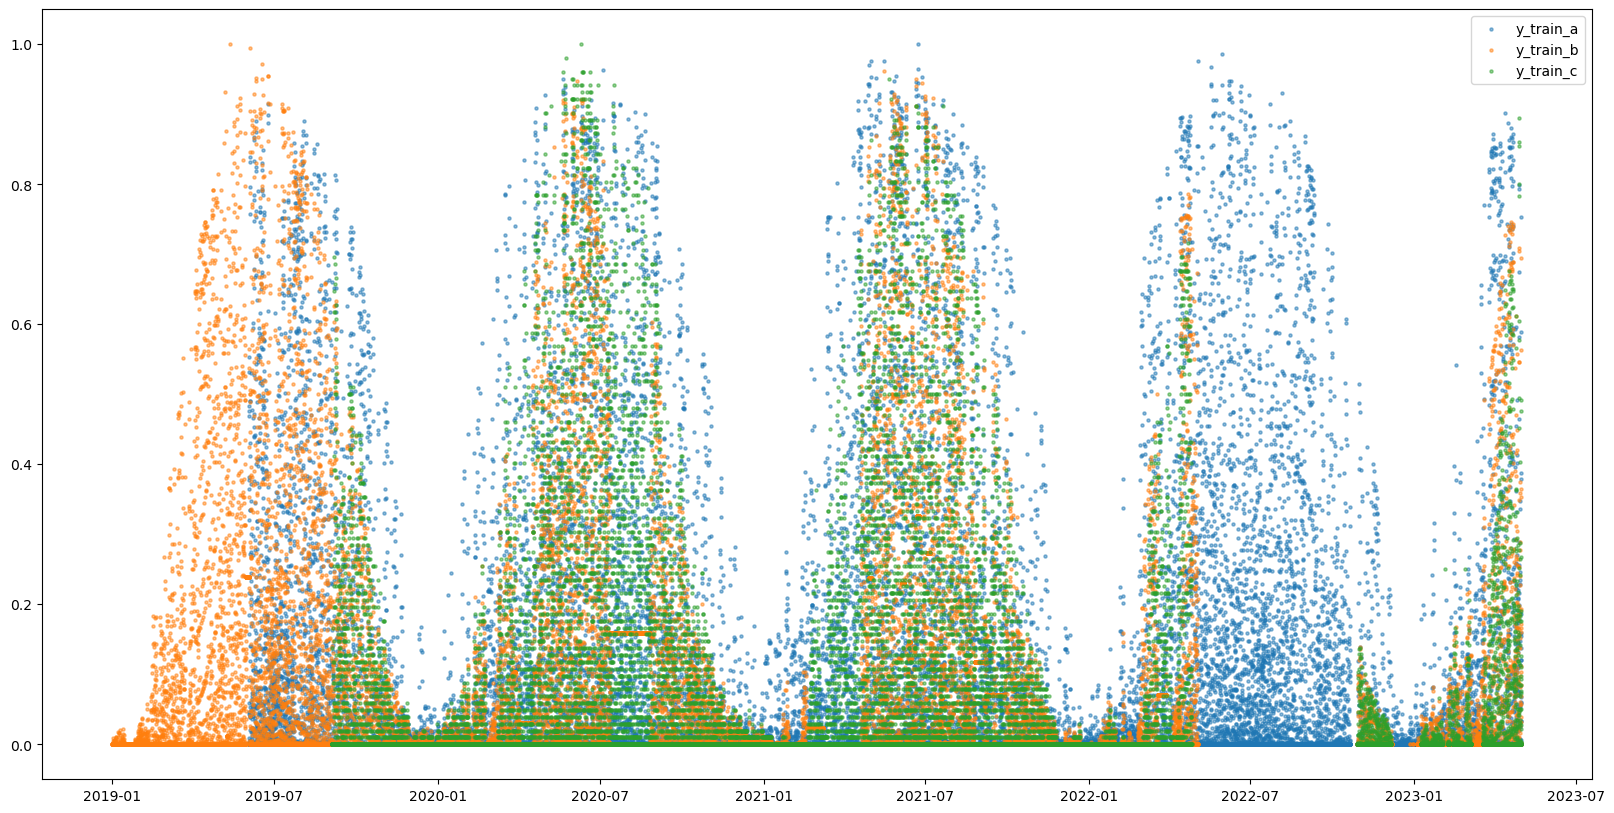

In [30]:
# Plot the y_test values for all the datasets avfter nomalizing each set 

#A
plt.figure(figsize=(20,10))
plt.scatter(y_train_a["time"], y_train_a["pv_measurement"], label="y_train_a", s=5, alpha=0.5)

#B
plt.scatter(y_train_b["time"],y_train_b["pv_measurement"], label="y_train_b", s=5, alpha=0.5)

#C
plt.scatter(y_train_c["time"],y_train_c["pv_measurement"], label="y_train_c",s=5, alpha=0.5)


plt.legend()

In [31]:
repeated_indices_b = find_repeated_indexes(y_train_b,"pv_measurement", 24)
repeated_indices_c = find_repeated_indexes(y_train_c,"pv_measurement", 24)

In [32]:
# Fill missing values from A to B and C


# Fix repeated values in B

print(len(repeated_indices_b))
timestamps_b = y_train_b.reset_index()[y_train_b.reset_index().index.isin(repeated_indices_b)]["time"]
filtered_a = y_train_a[y_train_a["time"].isin(timestamps_b)]
y_train_b.loc[y_train_b.time.isin(filtered_a.time), "pv_measurement"] = y_train_a[y_train_a["time"].isin(timestamps_b)]["pv_measurement"].values
repeated_indices_b = find_repeated_indexes(y_train_b,"pv_measurement", 24)
print(len(repeated_indices_b))

# Fix repeated values in C

print(len(repeated_indices_c))


timestamps_c = y_train_c.reset_index()[y_train_c.reset_index().index.isin(repeated_indices_c)]["time"]
filtered_a = y_train_a[y_train_a["time"].isin(timestamps_c)]
y_train_c.loc[y_train_c.time.isin(filtered_a.time), "pv_measurement"] = y_train_a[y_train_a["time"].isin(timestamps_c)]["pv_measurement"].values

repeated_indices_c = find_repeated_indexes(y_train_c,"pv_measurement", 24)
print(len(repeated_indices_c))


# Fill inn values in B and C between observed og estimated dataset, and NaN values
y_train_b = y_train_b.dropna()
y_train_c = y_train_c.dropna()

diff_times_b = y_train_a[~y_train_a["time"].isin(y_train_b["time"])]["time"]
diff_times_c = y_train_a[~y_train_a["time"].isin(y_train_c["time"])]["time"]

y_train_b = pd.concat([y_train_b, y_train_a[y_train_a["time"].isin(diff_times_b)]]).sort_values(by="time")
y_train_c = pd.concat([y_train_c, y_train_a[y_train_a["time"].isin(diff_times_c)]]).sort_values(by="time")



6889
514
4926
42


In [33]:
# Fix repeated values in B

filtered_a = X_train_a[X_train_a["date_forecast"].isin(timestamps_b)]
X_train_b.loc[X_train_b.date_forecast.isin(filtered_a.date_forecast)] = X_train_a[X_train_a["date_forecast"].isin(timestamps_b)]


# Fix repeated values in C

filtered_a = X_train_a[X_train_a["date_forecast"].isin(timestamps_c)]
X_train_c.loc[X_train_c.date_forecast.isin(filtered_a.date_forecast)] = X_train_a[X_train_a["date_forecast"].isin(timestamps_c)]


# Fill inn values in B and C between observed og estimated dataset, and NaN values
X_train_b = X_train_b[~X_train_b["date_forecast"].isin(diff_times_b)]
X_train_c = X_train_c[~X_train_c["date_forecast"].isin(diff_times_c)]

X_train_b = pd.concat([X_train_b, X_train_a[X_train_a["date_forecast"].isin(diff_times_b)]]).sort_values(by="date_forecast")
X_train_c = pd.concat([X_train_c, X_train_a[X_train_a["date_forecast"].isin(diff_times_c)]]).sort_values(by="date_forecast")


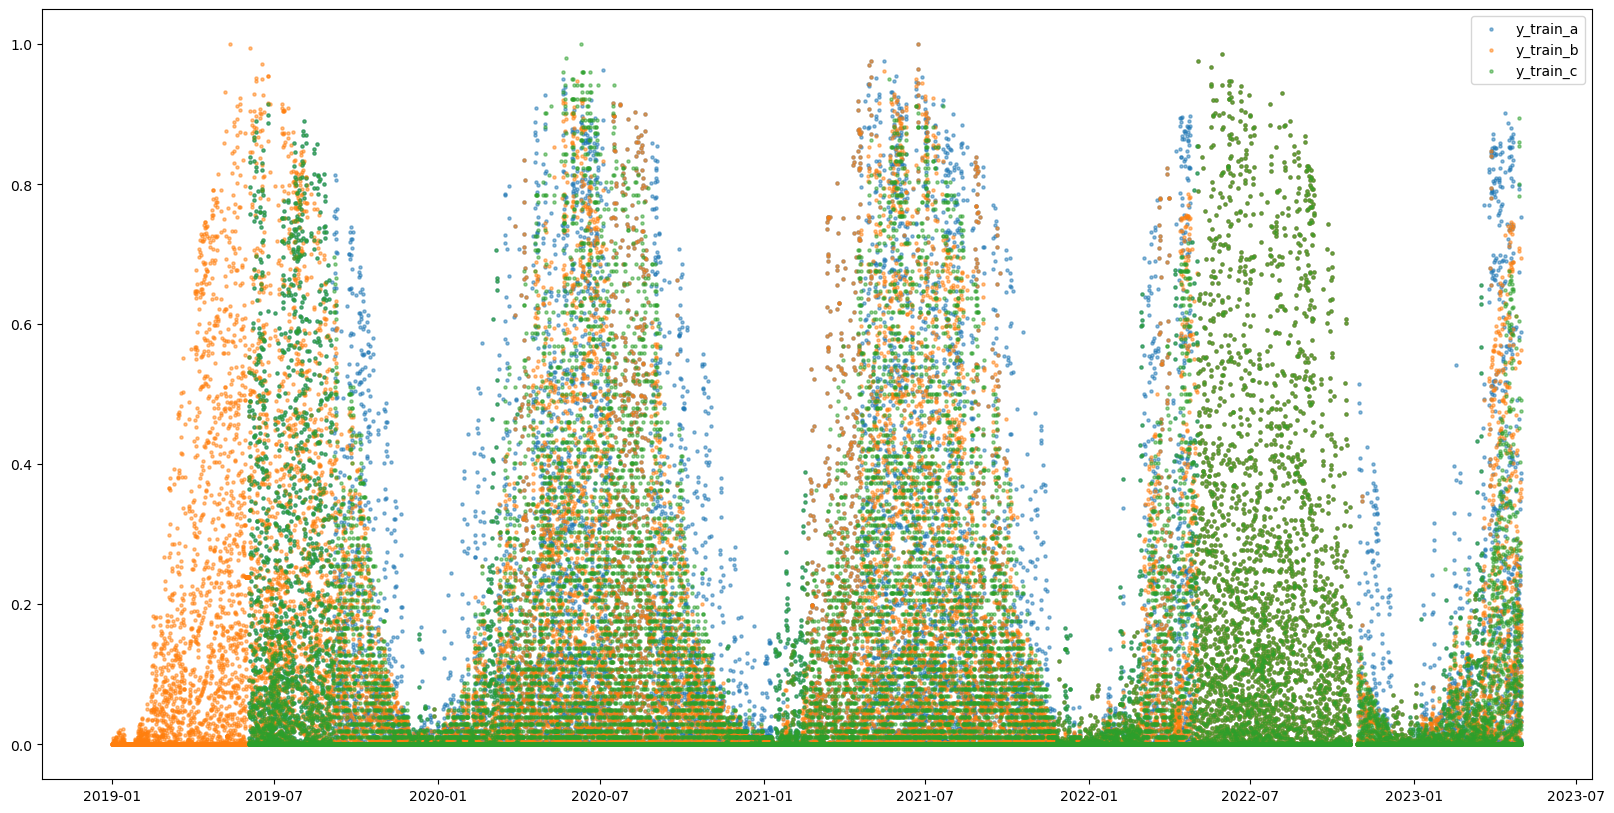

In [34]:
# Plot the y_test values for all the datasets after normalizing each set 

#A
plt.figure(figsize=(20,10))
plt.scatter(y_train_a["time"], y_train_a["pv_measurement"], label="y_train_a", s=5, alpha=0.5)

#B
plt.scatter(y_train_b["time"],y_train_b["pv_measurement"], label="y_train_b", s=5, alpha=0.5)

#C
plt.scatter(y_train_c["time"],y_train_c["pv_measurement"], label="y_train_c",s=5, alpha=0.5)

plt.legend()

In [35]:
X_train_b.describe().to_numpy()[0]

array([32535, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0,
       32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0,
       32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0,
       32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0,
       32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0,
       32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0, 32535.0,
       32535.0], dtype=object)

##### Drop time features

In [36]:
X_train_a.drop("date_forecast", axis=1, inplace=True)
y_train_a.drop("time", axis=1, inplace=True)
X_validate_a.drop("date_forecast", axis=1, inplace=True)
y_validate_a.drop("time", axis=1, inplace=True)

X_train_b.drop("date_forecast", axis=1, inplace=True)
y_train_b.drop("time", axis=1, inplace=True)
X_validate_b.drop("date_forecast", axis=1, inplace=True)
y_validate_b.drop("time", axis=1, inplace=True)

X_train_c.drop("date_forecast", axis=1, inplace=True)
y_train_c.drop("time", axis=1, inplace=True)
X_validate_c.drop("date_forecast", axis=1, inplace=True)
y_validate_c.drop("time", axis=1, inplace=True)

C:\Users\krist\AppData\Local\Temp\ipykernel_23048\2871152235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_validate_a.drop("time", axis=1, inplace=True)
C:\Users\krist\AppData\Local\Temp\ipykernel_23048\2871152235.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_validate_b.drop("time", axis=1, inplace=True)
C:\Users\krist\AppData\Local\Temp\ipykernel_23048\2871152235.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_v

# GRUDE END

Merging tranining data:


In [37]:
X_train = pd.concat([X_train_a, X_train_b, X_train_c])
y_train = pd.concat([y_train_a, y_train_b, y_train_c])

X_validate = pd.concat([X_validate_a, X_validate_b, X_validate_c])
y_validate = pd.concat([y_validate_a, y_validate_b, y_validate_c])

print(X_train.shape)
print(y_train.shape)

(105924, 43)
(105924, 2)


One-hot encoding

In [38]:
# one hot encoding and dropping location feature   some fuckery here
# one_hot = pd.get_dummies(X_train["location"]).astype(int)
# X_train = X_train.drop("location", axis=1)
# X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)


# one_hot = pd.get_dummies(X_validate["location"]).astype(int)
# X_validate = pd.merge(X_validate, one_hot, left_index=True, right_index=True)


# print(X_train.shape)
# print(y_train.shape)

One-hot encoding:


In [39]:
#adding location feature

X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"



In [40]:
# concatting:
X_test = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
# filtering out invalid dates:
X_test = X_test[X_test["date_forecast"].isin(load_valid_dates())]
# removing forecast coloum
X_test = X_test.drop("date_forecast", axis=1)

In [41]:
X_train = X_train.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_train["location"]).astype(int)
X_train = X_train.drop("location", axis=1)
X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)

X_validate = X_validate.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_validate["location"]).astype(int)
X_validate = X_validate.drop("location", axis=1)
X_validate = pd.merge(X_validate, one_hot, left_index=True, right_index=True)

X_test = X_test.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_test["location"]).astype(int)
X_test = X_test.drop("location", axis=1)
X_test = pd.merge(X_test, one_hot, left_index=True, right_index=True)

X_test
# one_hot

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear,A,B,C
0,0.316271,0.989998,0.000000,0.000000,0.0,0.938180,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0.312614,0.989421,0.000000,0.000000,0.0,0.937489,0.000000,0.000000,0.000000,0.000000,...,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0
2,0.303473,0.987690,0.000000,0.000000,0.0,0.936108,0.000000,0.000000,0.000000,0.000000,...,0.086957,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0
3,0.294333,0.986344,0.003389,0.013983,0.0,0.934726,0.030488,0.015331,0.003145,0.001576,...,0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0
4,0.285192,0.985574,0.047447,0.092071,0.0,0.933777,0.154146,0.093025,0.038110,0.020751,...,0.173913,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.594690,0.920223,0.159218,0.101463,0.0,0.971212,0.107342,0.154469,0.020153,0.022193,...,0.826087,0.066667,0.0,1.0,1.0,0.0,1.0,0,0,1
2156,0.608850,0.922722,0.061302,0.029383,0.0,0.972332,0.046254,0.078747,0.003596,0.011929,...,0.869565,0.066667,0.0,1.0,1.0,0.0,1.0,0,0,1
2157,0.628319,0.925413,0.012320,0.001466,0.0,0.973453,0.004167,0.025855,0.000000,0.001808,...,0.913043,0.066667,0.0,1.0,1.0,0.0,1.0,0,0,1
2158,0.637168,0.927720,0.000115,0.000000,0.0,0.974315,0.000000,0.002130,0.000000,0.000000,...,0.956522,0.066667,0.0,1.0,1.0,0.0,1.0,0,0,1


In [ ]:
# model = xgb.XGBRegressor(
#     max_depth=7,
#     colsample_bytree=0.8,
#     eta=0.1,
#     n_estimators=90,
#     reg_alpha=0.01,
#     reg_lambda=0.01,
#     enable_categorical=True
# )

# model.fit(X_train, y_train["pv_measurement"])

# X_validate_a_loc = X_validate[X_validate_a["location"]=="A"]
# X_validate_a_loc = X_validate_a_loc.drop("location", axis=1)

# prediction = model.predict(X_validate)

# prediction_a = model.predict(X_validate_a)
# prediction_b = model.predict(X_validate_b)
# prediction_c = model.predict(X_validate_c)

In [ ]:
# print(
#     "MAE: ",
#     round(
#         mean_absolute_error(
#             y_true=y_validate["pv_measurement"],
#             y_pred=prediction,
#         ),
#         3,
#     ),
# )

In [ ]:
# predicting:
# predict = model.predict(X_test)
# print(predict.head())
# predict = y_scaler.inverse_transform(predict.reshape(-1, 1))
# print(predict.head())

# resultframe = pd.DataFrame(columns = ["id", "prediction"])
# resultframe["prediction"] = predict
# print(resultframe.shape)
# resultframe["id"] = range(len(resultframe))
# resultframe.head()
# # making the csv
# # final = prediction.reset_index().reset_index().rename(columns={"level_0": "id", "y": "prediction"})[["id", "prediction"]]

# resultframe.to_csv("submission_super_all_the_guys_6.csv", index=False)

In [ ]:
X_test.head()

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

X_train = X_train.reset_index().drop(columns="index")
y_train = y_train.reset_index().drop(columns="index")
new_train = pd.merge(X_train, y_train["pv_measurement"], left_index=True, right_index=True)

X_validate = X_validate.reset_index().drop(columns="index")
y_validate = y_validate.reset_index().drop(columns="index")
new_validate = pd.merge(X_validate, y_validate["pv_measurement"], left_index=True, right_index=True)

h2o_train= h2o.H2OFrame(new_train)
h2o_validate= h2o.H2OFrame(new_validate)
h2o_test = h2o.H2OFrame(X_test)

aml = H2OAutoML(max_models=20, seed=1, stopping_metric="MAE", sort_metric="MAE", stopping_tolerance=0.01)
# aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train, validation_frame=h2o_validate)
aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)
lb = aml.leaderboard
preds = aml.leader.predict(h2o_test)



In [ ]:

lb.head(rows=lb.nrows)

In [ ]:
preds.head()


In [ ]:
leaderboard_df = lb.as_data_frame() 
prediction_df = preds.as_data_frame()

In [ ]:
h2o.cluster().shutdown()

In [ ]:
print(prediction_df)



In [ ]:
# prediction_df_arr = prediction_df.reshape(-1, 1)
prediction_df_scaled = y_scaler.inverse_transform(prediction_df)

In [ ]:
print(prediction_df_scaled)
prediction_df_scaled_df = pd.DataFrame(prediction_df_scaled)
print(prediction_df_scaled_df)

Removing negative values and replacing with 0

In [ ]:
resultframe = pd.DataFrame(columns = ["id", "prediction"])
resultframe["prediction"] = prediction_df_scaled_df
resultframe['prediction'] = np.where(resultframe['prediction'] < 0, 0, resultframe['prediction'])
resultframe["id"] = range(len(resultframe))
resultframe.head()

#### Okay lets create a submission

In [ ]:

resultframe.to_csv("sumbission_all_the_boys_1.csv", index=False)

In [ ]:
# df = pd.read_csv("submission_sivert_super_model_5.csv")

# df['prediction'] = np.where(df['prediction'] < 0, 0, df['prediction'])
# df['prediction'] = np.where(df['prediction'] > 0, df['prediction']+3, 0)
# df.describe()
# df.to_csv("submission_sivert_super_model_5_with_no_negatives_copy_plus_scaled.csv", index=False)
